# 任务介绍
零售电商的客户分析，基于RFM模型实现客户细分，并根据结果给出客户维护决策。
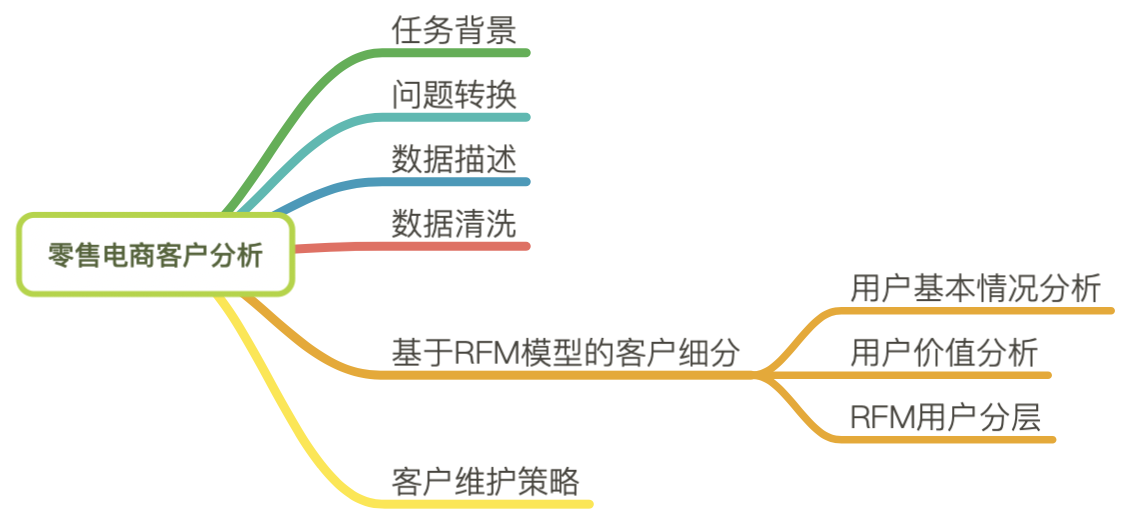



# 任务背景
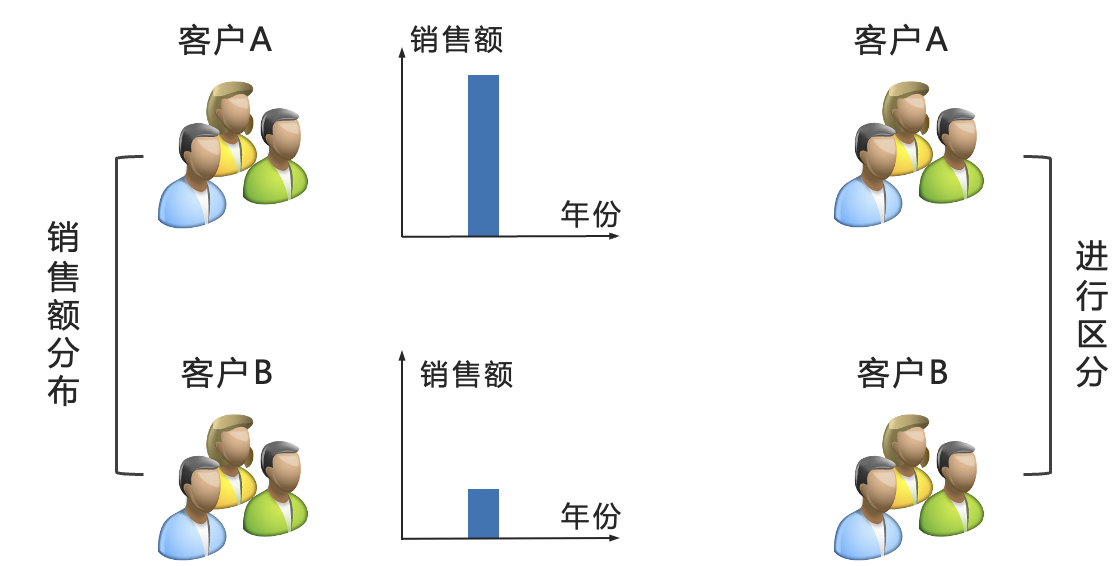

营销学之父菲利普科特勒曾研究发现，企业获得一个新客户的成本是维护一个老客户的5倍，流失率降低5%，利润增长25%以上。
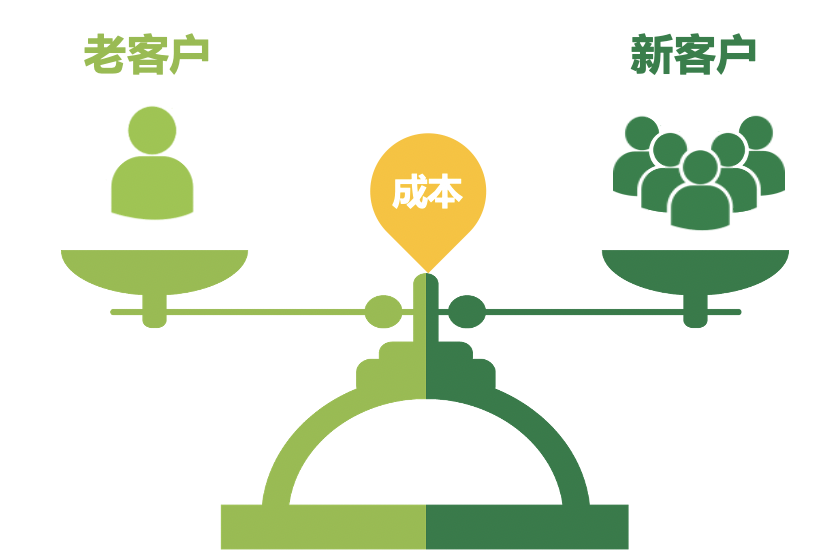

企业资源有限，无法照顾到所有客户

企业很难让所有客户满意。

问题：如何实现客户差异化管理

# 问题转换
业务问题：分析客户差异性，根据差异性维护客户

数据问题：通过RFM模型实现客户细分
- 用户基本情况分析
- RFM用户价值分析

# 数据描述
零售客户数据提供了有关所售商品的数量、特征和价值以及价格的详细信息。
- Date：购买日期
- Customer_ID：用户ID
- Transaction_ID：交易ID
- SKU_Category：商品分类SKU编码
- SKU：商品唯一SKU编码
- Quantity：购买数量
- Sales_Amount：购买金额

# 数据清洗

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [2]:
#plt.rcParams['font.sans-serif'] = 'WenQuanYi Zen Hei'
#plt.rcParams['axes.unicode_minus'] = False
#设置字体 Windows
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来显示中文
plt.rcParams["axes.unicode_minus"] = False  # 用来显示负号

In [11]:
df= pd.read_csv('./retail_data.csv')
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


1. 第一列为编号，已有索引，删除

In [12]:
df.drop(columns='Unnamed: 0',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            131706 non-null  object 
 1   Customer_ID     131706 non-null  int64  
 2   Transaction_ID  131706 non-null  int64  
 3   SKU_Category    131706 non-null  object 
 4   SKU             131706 non-null  object 
 5   Quantity        131706 non-null  float64
 6   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 7.0+ MB


2.重复值检测

In [13]:
df.duplicated().sum()

0

3.缺失值检测与处理

In [14]:
df.isnull().sum()

Date              0
Customer_ID       0
Transaction_ID    0
SKU_Category      0
SKU               0
Quantity          0
Sales_Amount      0
dtype: int64

In [15]:
df.dtypes

Date               object
Customer_ID         int64
Transaction_ID      int64
SKU_Category       object
SKU                object
Quantity          float64
Sales_Amount      float64
dtype: object

4.数据描述

In [16]:
df[['Quantity','Sales_Amount']].describe()

,Quantity,Sales_Amount
count,131706.000000,131706.000000
mean,1.485311,11.981524
std,3.872667,19.359699
min,0.010000,0.020000
25%,1.000000,4.230000
50%,1.000000,6.920000
75%,1.000000,12.330000
max,400.000000,707.730000


# 基于RFM模型的客户细分

## 用户基本情况分析
（1）每月消费总金额趋势分析

In [20]:
df['Month']=df.Date.astype('datetime64[M]')
df.head()

/tmp/ipykernel_87/2305855002.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Month']=df.Date.astype('datetime64[M]')


,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Month
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13,2016-02-01
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46,2016-02-01
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59,2016-02-01
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01


In [25]:
df.Sales_Amount.sum()

1578038.6199999999

In [26]:
group_month=df.groupby('Month').agg(总金额=('Sales_Amount','sum'))
group_month

,总金额
Month,
2016-01-01,117284.11
2016-02-01,117005.29
2016-03-01,126225.65
2016-04-01,134523.44
2016-05-01,142155.20
2016-06-01,124767.33
2016-07-01,124108.75
2016-08-01,128139.95
2016-09-01,148277.18


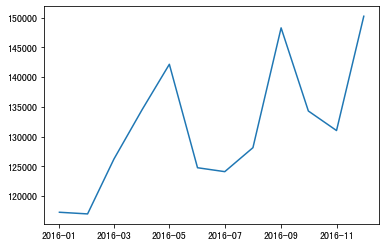

In [27]:
plt.plot(group_month)

由图可知：消费金额波动较大，其中一季度持续上升状态，后续波动大，整体呈上升趋势。

（2）每月消费人数趋势分析

In [28]:
df.Customer_ID.nunique()

22625

In [29]:
group_month_count=df.groupby('Month').agg(消费人数=('Customer_ID','nunique'))


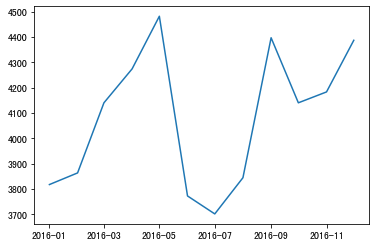

In [30]:
plt.plot(group_month_count)

## 用户价值分析


* R：又称最小间隔天数，一段时间内，客户最近一次交易日期，距时间段终点越近越好。
* F：一段时间内，客户交易的次数，次数越多越好。
* M：一段时间内，客户的交易度量（如：金额，利润，利润率），越大越好。

1. R 值分布

In [31]:
df.MD.max()

Timestamp('2016-12-31 00:00:00')

In [32]:
df['MD']=df.Date.astype('datetime64[D]')

/tmp/ipykernel_68/875348856.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['MD']=df.Date.astype('datetime64[D]')


In [33]:
df['R']=(df.MD.max()-df.MD).dt.days
df

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Month,MD,R
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-02-01,334
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-02-01,334
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-02-01,334
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-02-01,334
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01,334
...,...,...,...,...,...,...,...,...,...,...
131701,04/07/2016,20203,32900,IEV,FO112,3.0,6.46,2016-04-01,2016-04-07,268
131702,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50,2016-04-01,2016-04-07,268
131703,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19,2016-04-01,2016-04-07,268
131704,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57,2016-04-01,2016-04-07,268


In [34]:
customer_R=df.groupby('Customer_ID').agg(最小间隔天数=('R','min'))
customer_R

,最小间隔天数
Customer_ID,
1,344
2,195
3,334
4,54
5,120
...,...
22621,80
22622,15
22623,10


(array([4969., 3088., 2646., 1799., 1780., 1657., 1755., 1907., 1611.,
        1413.]),
 array([  0. ,  36.4,  72.8, 109.2, 145.6, 182. , 218.4, 254.8, 291.2,
        327.6, 364. ]),
 <BarContainer object of 10 artists>)

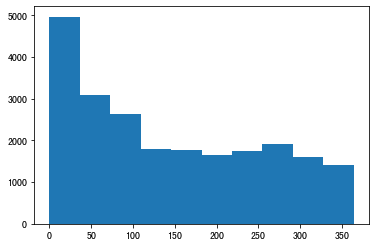

In [35]:
plt.hist(customer_R['最小间隔天数'])

2. M 值分布

In [36]:
df

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Month,MD,R
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-02-01,334
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-02-01,334
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-02-01,334
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-02-01,334
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01,334
...,...,...,...,...,...,...,...,...,...,...
131701,04/07/2016,20203,32900,IEV,FO112,3.0,6.46,2016-04-01,2016-04-07,268
131702,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50,2016-04-01,2016-04-07,268
131703,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19,2016-04-01,2016-04-07,268
131704,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57,2016-04-01,2016-04-07,268


In [37]:
customer_M=df.groupby('Customer_ID').agg(消费总金额=('Sales_Amount','sum'))
customer_M

,消费总金额
Customer_ID,
1,16.29
2,22.77
3,10.92
4,33.29
5,78.82
...,...
22621,9.69
22622,6.07
22623,128.01


In [38]:
customer_M_sort=customer_M.sort_values(by='消费总金额',ascending=False)

In [39]:
customer_M_sort

,消费总金额
Customer_ID,
17471,3985.94
17104,3844.97
17294,3798.39
15540,2900.61
15677,2765.16
...,...
20576,0.34
2852,0.30
19152,0.27


In [40]:
customer_M_sort['累积求和']=customer_M_sort['消费总金额'].cumsum(axis=0)
customer_M_sort['累积占比']=round(customer_M_sort['累积求和']/customer_M_sort['消费总金额'].sum(),4)
customer_M_sort.head(4400)

,消费总金额,累积求和,累积占比
Customer_ID,,,
17471,3985.94,3985.94,0.0025
17104,3844.97,7830.91,0.0050
17294,3798.39,11629.30,0.0074
15540,2900.61,14529.91,0.0092
15677,2765.16,17295.07,0.0110
...,...,...,...
10592,83.78,1139935.92,0.7224
13492,83.71,1140019.63,0.7224
8978,83.70,1140103.33,0.7225


意大利经济学家帕累托发现：任何一组东西中，最重要的只占其一小部分，约20%，其余尽管是大多数，却是次要的。
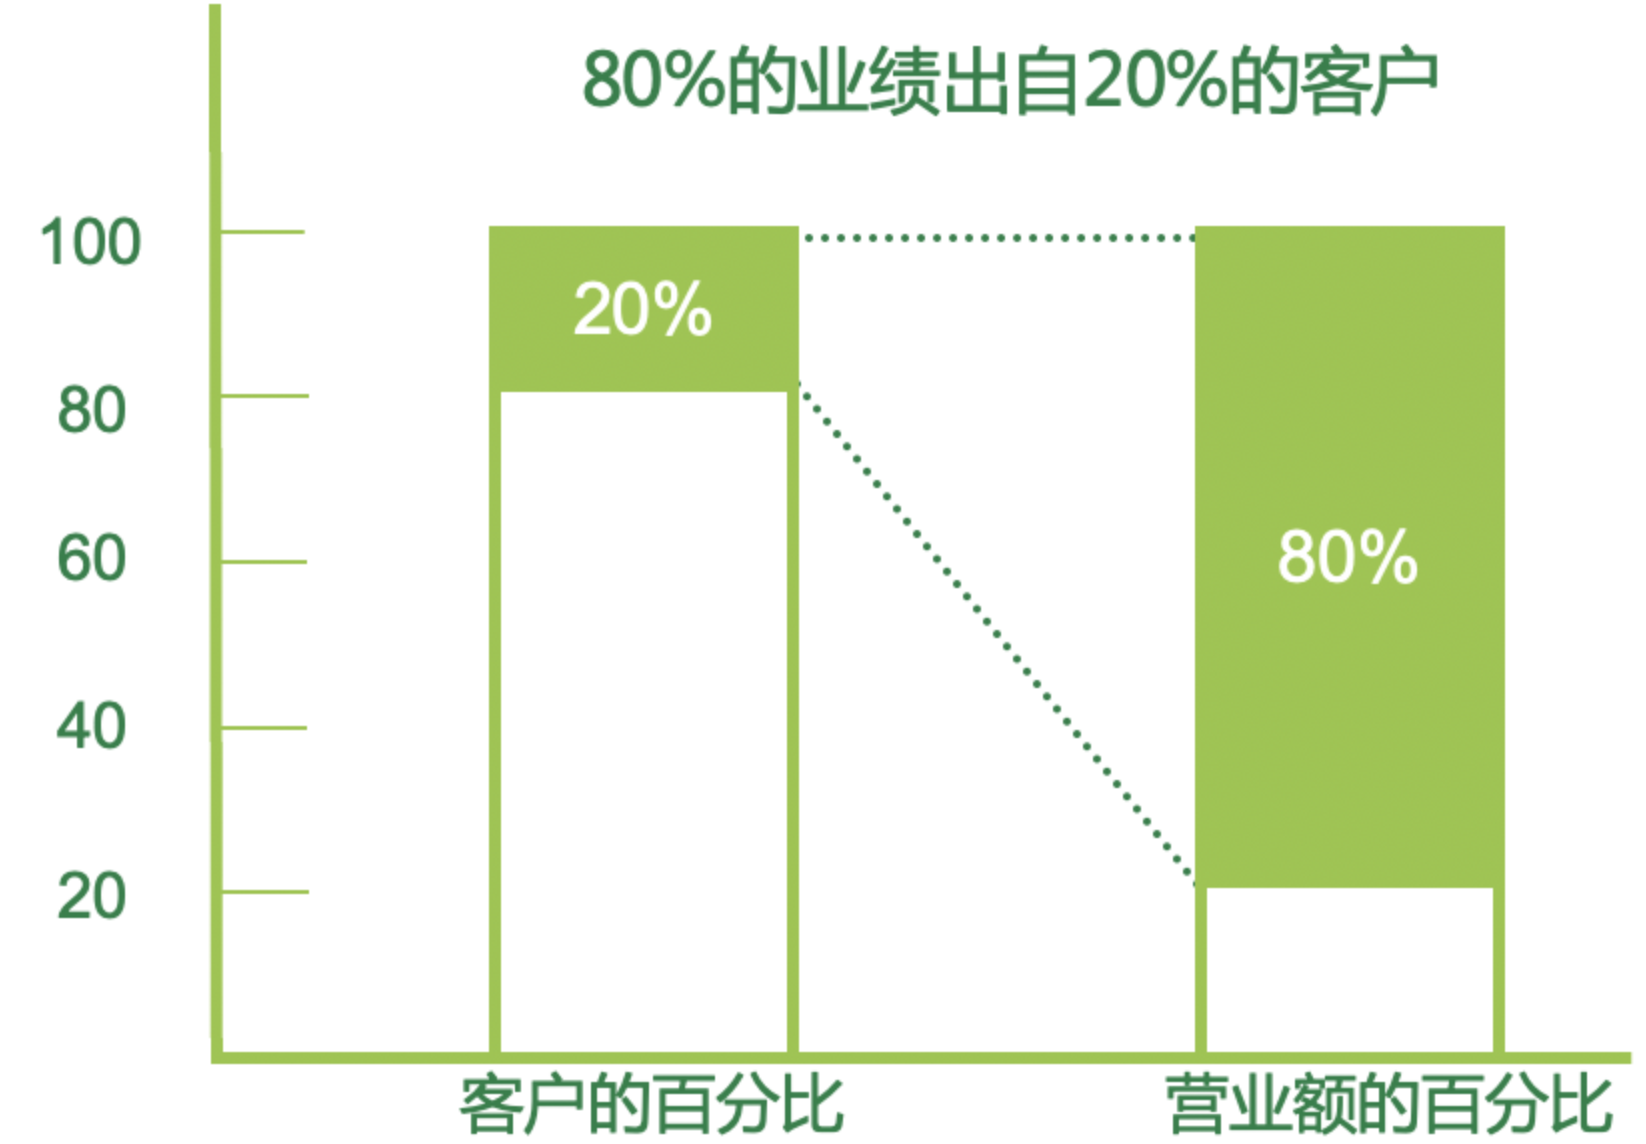

3. F 值分布

In [41]:
customer_F=df.groupby('Customer_ID').agg(交易频次=('Transaction_ID','nunique'))
customer_F

,交易频次
Customer_ID,
1,1
2,2
3,1
4,2
5,5
...,...
22621,1
22622,1
22623,1


(array([2.1717e+04, 7.0500e+02, 1.5100e+02, 3.1000e+01, 7.0000e+00,
        6.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <BarContainer object of 10 artists>)

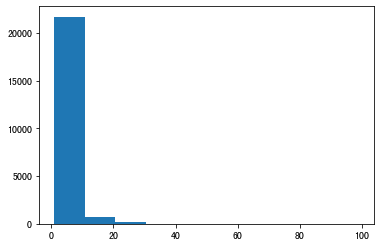

In [42]:
plt.hist(customer_F['交易频次'])

## RFM用户分层

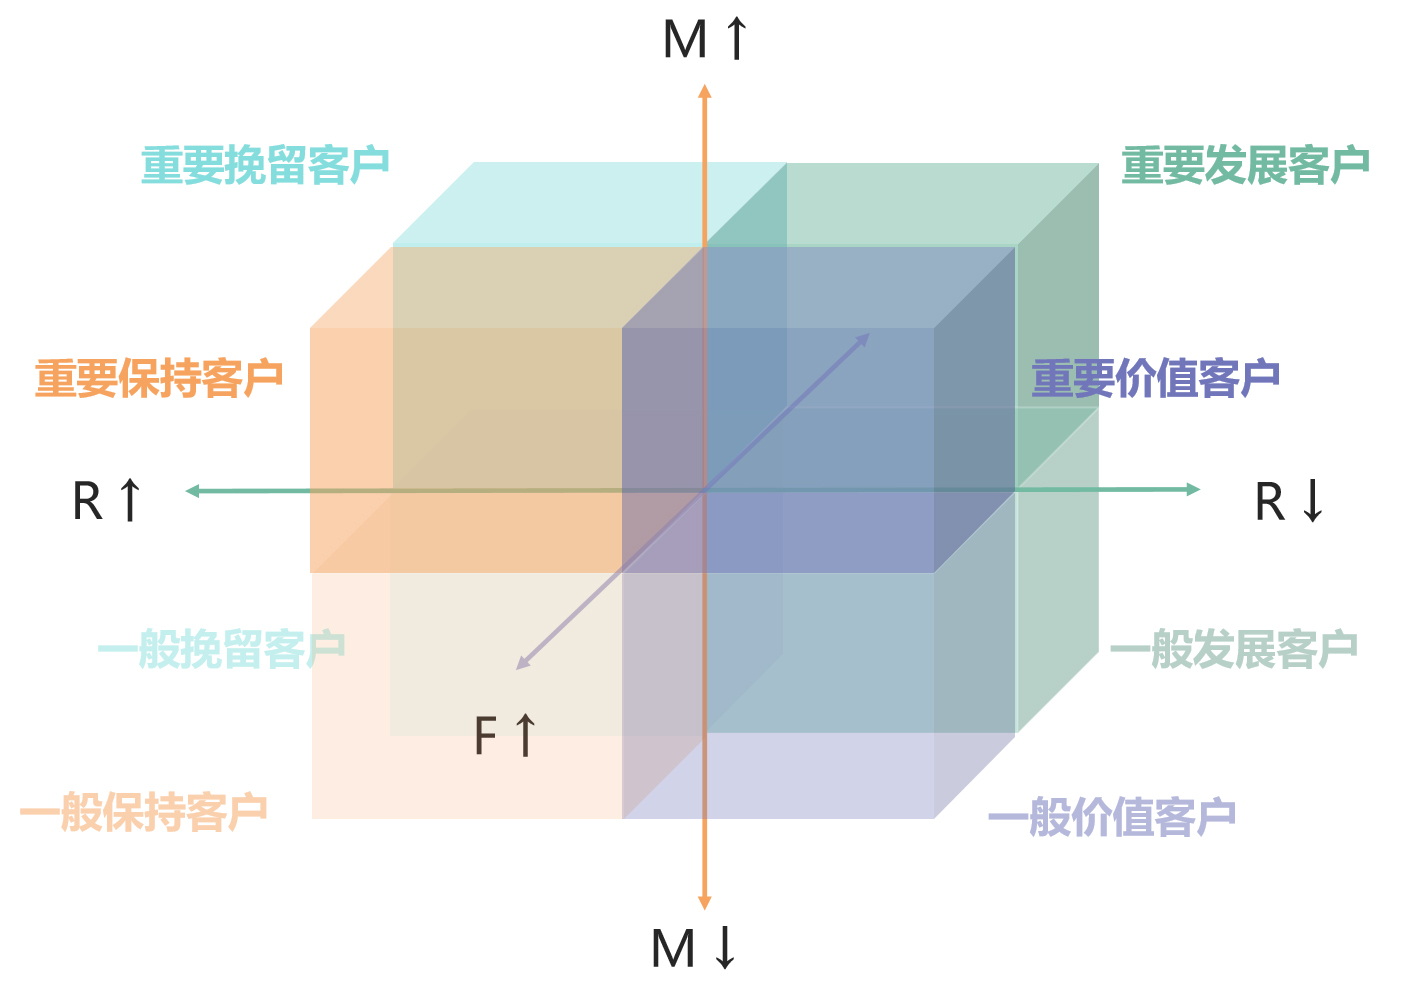

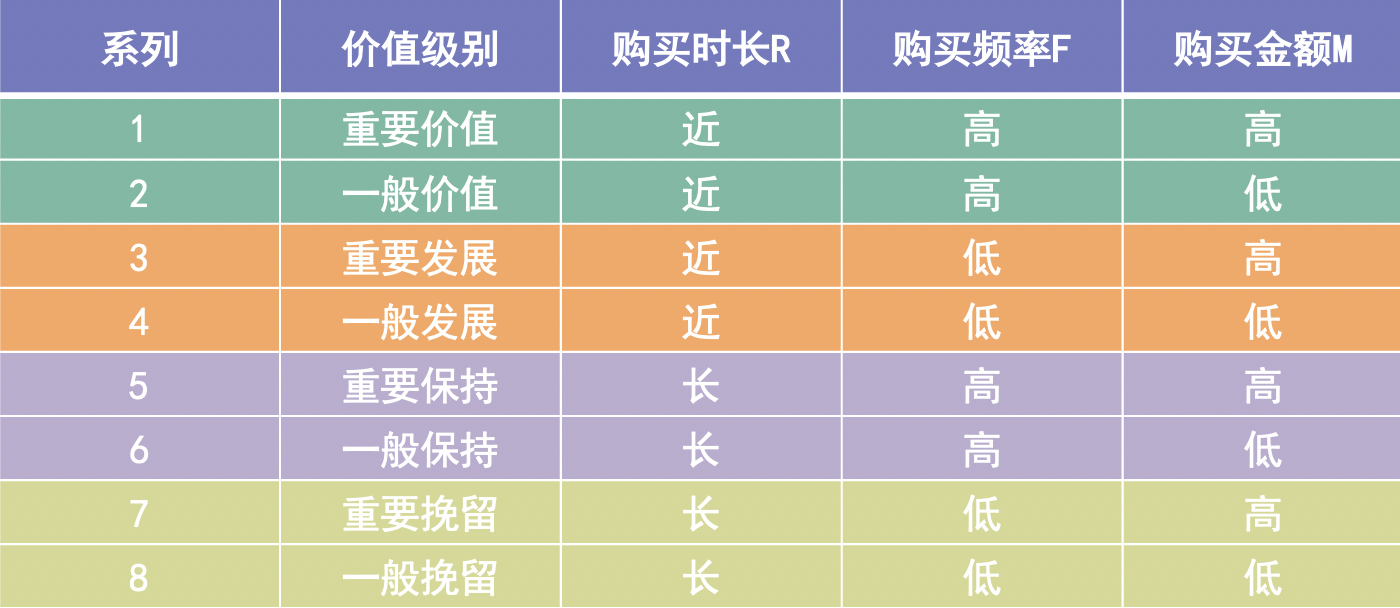

In [44]:
pivot_rfm=df.pivot_table(index='Customer_ID',
                        values=['R','Transaction_ID','Sales_Amount'],
                        aggfunc={'R':'min','Transaction_ID':'nunique','Sales_Amount':'sum'})

In [45]:
pivot_rfm

,R,Sales_Amount,Transaction_ID
Customer_ID,,,
1,344,16.29,1
2,195,22.77,2
3,334,10.92,1
4,54,33.29,2
5,120,78.82,5
...,...,...,...
22621,80,9.69,1
22622,15,6.07,1
22623,10,128.01,1


In [46]:
pivot_rfm.rename(columns={'Transaction_ID':'F','Sales_Amount':'M'},inplace=True)

In [47]:
pivot_rfm

,R,M,F
Customer_ID,,,
1,344,16.29,1
2,195,22.77,2
3,334,10.92,1
4,54,33.29,2
5,120,78.82,5
...,...,...,...
22621,80,9.69,1
22622,15,6.07,1
22623,10,128.01,1


In [48]:
pivot_rfm.mean()

R    144.408796
M     69.747563
F      2.858873
dtype: float64

In [49]:
pivot_rfm[['R','F','M']].apply(lambda x:x-x.mean())

,R,F,M
Customer_ID,,,
1,199.591204,-1.858873,-53.457563
2,50.591204,-0.858873,-46.977563
3,189.591204,-1.858873,-58.827563
4,-90.408796,-0.858873,-36.457563
5,-24.408796,2.141127,9.072437
...,...,...,...
22621,-64.408796,-1.858873,-60.057563
22622,-129.408796,-1.858873,-63.677563
22623,-134.408796,-1.858873,58.262437


In [50]:
def label_func(data):
    label =data.apply(lambda x: '1' if x>0 else '0')
    label =label.R+label.F+label.M
    labels ={
        '011':'重要价值用户',
        '111':'重要保持用户',
        '001':'重要发展用户',
        '101':'重要挽留用户',
        '010':'一般价值用户',
        '110':'一般保持用户',
        '000':'一般发展用户',
        '100':'一般挽留用户'
    }
    return labels[label]
pivot_rfm['label']=pivot_rfm[['R','F','M']].apply(lambda x:x-x.mean()).apply(label_func,axis=1)

<AxesSubplot: >

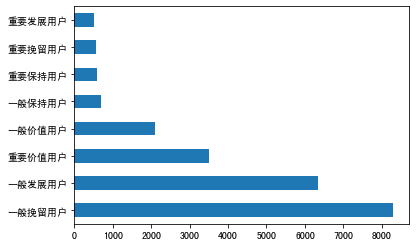

In [51]:
pivot_rfm.label.value_counts().plot.barh()

<AxesSubplot: ylabel='M'>

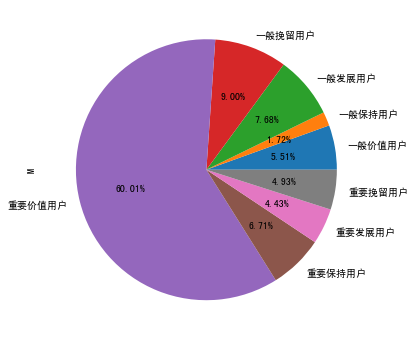

In [52]:
pivot_rfm.groupby('label').M.sum().plot.pie(figsize=(6,6),autopct='%.2f%%')

In [53]:
pivot_rfm.groupby('label').agg(['sum','count'])

R                M            F      
            sum count        sum count    sum count
label                                              
一般价值用户   113626  2091   86991.78  2091   8339  2091
一般保持用户   154884   702   27186.30   702   2475   702
一般发展用户   428607  6351  121152.11  6351   8375  6351
一般挽留用户  2124121  8291  142011.02  8291   9872  8291
重要价值用户   137033  3504  947045.76  3504  31205  3504
重要保持用户   127030   593  105906.86   593   2728   593
重要发展用户    35418   517   69872.03   517    851   517
重要挽留用户   146530   576   77872.76   576    837   576

In [54]:
pivot_rfm

,R,M,F,label
Customer_ID,,,,
1,344,16.29,1,一般挽留用户
2,195,22.77,2,一般挽留用户
3,334,10.92,1,一般挽留用户
4,54,33.29,2,一般发展用户
5,120,78.82,5,重要价值用户
...,...,...,...,...
22621,80,9.69,1,一般发展用户
22622,15,6.07,1,一般发展用户
22623,10,128.01,1,重要发展用户


# 用户维护策略


- 销售额主要来源**重要价值客户**，人数占比最高的为**一般挽留客户**
- 重要发展客户：近期有消费，且消费高，消费频率不足，可以适当举行营销活动，提升此层客户的购买频率
- 重要价值客户：销售额的主要来源，近期有消费，消费高，频率高，尽可能使该层客户保持现状
- 重要保持客户：消费以及消费频次高，近期没有消费，可以使用适当策略召回用户，参与消费
- 重要挽留客户：消费高，但频次低且近期未消费，处在流失的边缘，可以通过适当活动，使其参与到消费中来，防止流失
- 一般价值客户：消费低，消费频率高且近期有消费，可以使用优惠券等形式活动刺激该层客户的消费，提升其消费额
- 一般发展客户：近期有消费，但消费额以及消费频次不高，考虑到人数占比高，可以适当举办活动提升消费频次和消费额
- 一般保持客户：在成本与资源控制下，酌情考虑
- 一般挽留客户：人数占比高，在成本与资源控制下，酌情考虑

***
# <center> 练一练 
***

**散点图是可视化图表中表示关联的图表，请用散点图展示客户的R值、M值、F值两两之间的分布，并分析其分布特点。**

In [55]:
# 请写出满足以上题目要求的运行Python代码


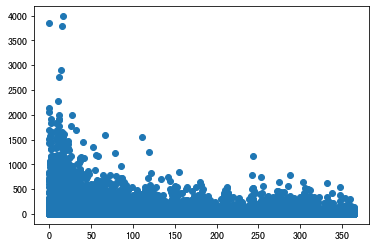

In [56]:
plt.scatter(x='R', y='M', data=pivot_rfm)